# Автокодировщики

## Простейший автокодировщик

In [1]:
from keras.datasets import mnist
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

In [2]:
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model

In [3]:
encoding_dim = 49

# Энкодер
input_img = Input(shape=(28, 28, 1)) # 28, 28, 1 - размерности строк, столбцов, фильтров одной картинки
flat_img = Flatten()(input_img)
# Кодированное полносвязным слоем представление
encoded = Dense(encoding_dim, activation='relu')(flat_img)

# Декодер
input_encoded = Input(shape=(encoding_dim,))
flat_decoded = Dense(28*28, activation='sigmoid')(input_encoded)
decoded = Reshape((28, 28, 1))(flat_decoded)

encoder = Model(input_img, encoded, name="encoder")
decoder = Model(input_encoded, decoded, name="decoder")
autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")

In [4]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [5]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 49)                38465     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         39200     
Total params: 77,665
Trainable params: 77,665
Non-trainable params: 0
_________________________________________________________________


In [6]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50


InternalError:  Blas xGEMM launch failed : a.shape=[1,256,784], b.shape=[1,784,49], m=256, n=49, k=784
	 [[node autoencoder/encoder/dense/MatMul (defined at /home/uadmin/.local/lib/python3.8/site-packages/keras/layers/core.py:1222) ]] [Op:__inference_train_function_716]

Errors may have originated from an input operation.
Input Source operations connected to node autoencoder/encoder/dense/MatMul:
 autoencoder/encoder/flatten/Reshape (defined at /home/uadmin/.local/lib/python3.8/site-packages/keras/layers/core.py:672)

Function call stack:
train_function


In [ ]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
n = 10

imgs = x_test[:n]
encoded_imgs = encoder.predict(imgs, batch_size=n)

In [ ]:
decoded_imgs = decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

## Многослойный автокодировщик

In [ ]:
encoding_dim = 49

# Энкодер
input_img = Input(shape=(28, 28, 1))
flat_img = Flatten()(input_img)
x = Dense(encoding_dim*3, activation='relu')(flat_img)
x = Dense(encoding_dim*2, activation='relu')(x)
encoded = Dense(encoding_dim, activation='linear')(x)

# Декодер
input_encoded = Input(shape=(encoding_dim,))
x = Dense(encoding_dim*2, activation='relu')(input_encoded)
x = Dense(encoding_dim*3, activation='relu')(x)
flat_decoded = Dense(28*28, activation='sigmoid')(x)
decoded = Reshape((28, 28, 1))(flat_decoded)

# Модели
encoder = Model(input_img, encoded, name="encoder")
decoder = Model(input_encoded, decoded, name="decoder")
autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

In [ ]:
autoencoder.fit(x_train, x_train,
                  epochs=50,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(x_test, x_test))

In [ ]:
n = 10

imgs = x_test[:n]
encoded_imgs = encoder.predict(imgs, batch_size=n)
decoded_imgs = decoder.predict(encoded_imgs, batch_size=n)
plot_digits(imgs, decoded_imgs)

## Сверточный автокодировщик

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (7, 7), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(1, (7, 7), activation='relu', padding='same')(x)

input_encoded = Input(shape=(7, 7, 1))
x = Conv2D(128, (7, 7), activation='relu', padding='same')(input_encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(x)

# Модели
encoder = Model(input_img, encoded, name="encoder")
decoder = Model(input_encoded, decoded, name="decoder")
conv_autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")

conv_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

conv_autoencoder.summary()

In [9]:
conv_autoencoder.fit(x_train, x_train,
                epochs=3,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/3
 87/235 [==========>...................] - ETA: 1:23 - loss: 0.4690

KeyboardInterrupt: 

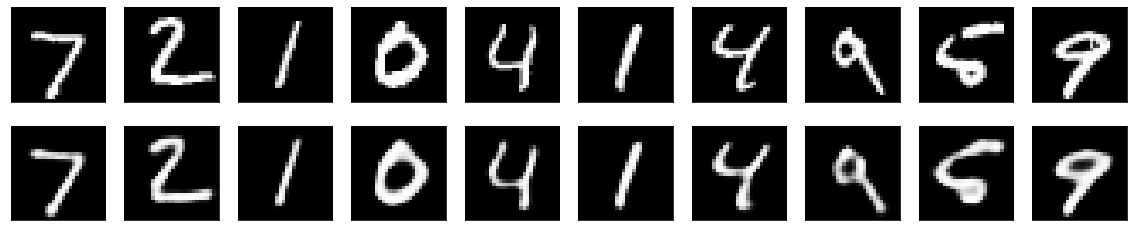

In [108]:
n = 10

imgs = x_test[:n]
encoded_imgs = encoder.predict(imgs, batch_size=n)
decoded_imgs = decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs, decoded_imgs)

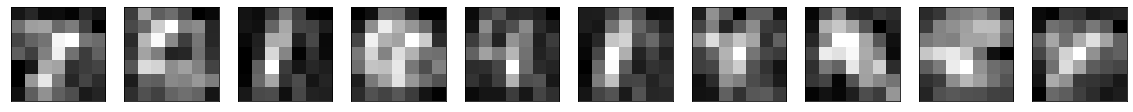

In [109]:
plot_digits(encoded_imgs)

## Шумоподавляющий автокодировщик

In [7]:
import keras.backend as K
from keras.layers import Lambda

batch_size = 16

def create_denoising_model(autoencoder):
    def add_noise(x):
        noise_factor = 0.5
        x = x + K.random_normal(x.get_shape(), 0.5, noise_factor)
        x = K.clip(x, 0., 1.)
        return x

    input_img  = Input(batch_shape=(batch_size, 28, 28, 1))
    noised_img = Lambda(add_noise)(input_img)

    noiser = Model(input_img, noised_img, name="noiser")
    denoiser_model = Model(input_img, conv_autoencoder(noiser(input_img)), name="denoiser")
    return noiser, denoiser_model


noiser, denoiser_model = create_denoising_model(autoencoder)
denoiser_model.compile(optimizer='adam', loss='binary_crossentropy')

NameError: name 'conv_autoencoder' is not defined

In [74]:
denoiser_model.fit(x_train, x_train,
                   epochs=5,
                   batch_size=batch_size,
                   shuffle=True,
                   validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 29s 488us/step - loss: 0.1090 - val_loss: 0.0947
Epoch 2/5
60000/60000 [==============================] - 32s 532us/step - loss: 0.0924 - val_loss: 0.0884
Epoch 3/5
60000/60000 [==============================] - 31s 524us/step - loss: 0.0890 - val_loss: 0.0866
Epoch 4/5
60000/60000 [==============================] - 32s 528us/step - loss: 0.0872 - val_loss: 0.0850
Epoch 5/5
60000/60000 [==============================] - 29s 479us/step - loss: 0.0860 - val_loss: 0.0847


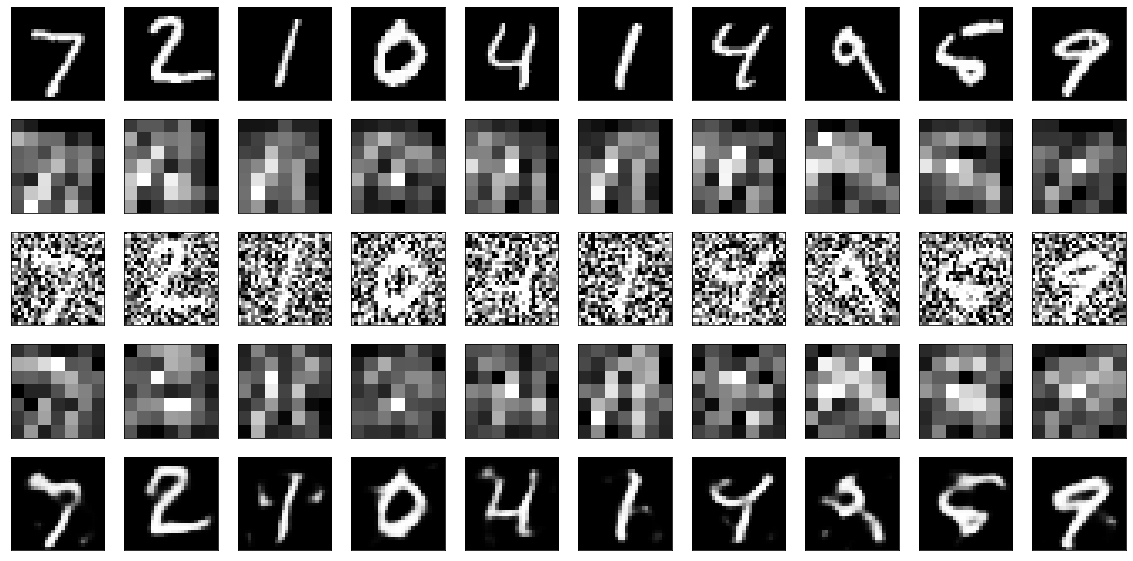

In [81]:
n = 10

imgs = x_test[:batch_size]
noised_imgs = noiser.predict(imgs, batch_size=batch_size)
encoded_original_imgs = encoder.predict(imgs[:n],  batch_size=n)
encoded_imgs = encoder.predict(noised_imgs[:n],  batch_size=n)
decoded_imgs = decoder.predict(encoded_imgs[:n], batch_size=n)

plot_digits(imgs[:n], encoded_original_imgs, noised_imgs, encoded_imgs, decoded_imgs)

## Разреженный автокодировщик

In [179]:
from keras.regularizers import L1L2
from keras import optimizers

encoding_dim = 49
lambda_l2 = 0.0005

# Энкодер
input_img = Input(shape=(28, 28, 1))
flat_img = Flatten()(input_img)
x = Dense(encoding_dim*3, activation='relu')(flat_img)
x = Dense(encoding_dim*2, activation='relu')(x)
encoded = Dense(encoding_dim, activation='linear', activity_regularizer=L1L2(l2=lambda_l2))(x)

# Декодер
input_encoded = Input(shape=(encoding_dim,))
x = Dense(encoding_dim*2, activation='relu')(input_encoded)
x = Dense(encoding_dim*3, activation='relu')(x)
flat_decoded = Dense(28*28, activation='sigmoid')(x)
decoded = Reshape((28, 28, 1))(flat_decoded)

# Модели
encoder = Model(input_img, encoded, name="encoder")
decoder = Model(input_encoded, decoded, name="decoder")
autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")

autoencoder.compile(optimizer=optimizers.adam(learning_rate=0.006), loss='binary_crossentropy')

In [180]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.2711 - val_loss: 0.2381
Epoch 2/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.2366 - val_loss: 0.2327
Epoch 3/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.2258 - val_loss: 0.2148
Epoch 4/100
60000/60000 [==============================] - 1s 21us/step - loss: 0.2036 - val_loss: 0.1945
Epoch 5/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.1897 - val_loss: 0.1853
Epoch 6/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.1791 - val_loss: 0.1737
Epoch 7/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.1713 - val_loss: 0.1692
Epoch 8/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.1679 - val_loss: 0.1673
Epoch 9/100
60000/60000 [==============================] - 1s 20us/step - loss: 0.1658 - val_loss: 0.1

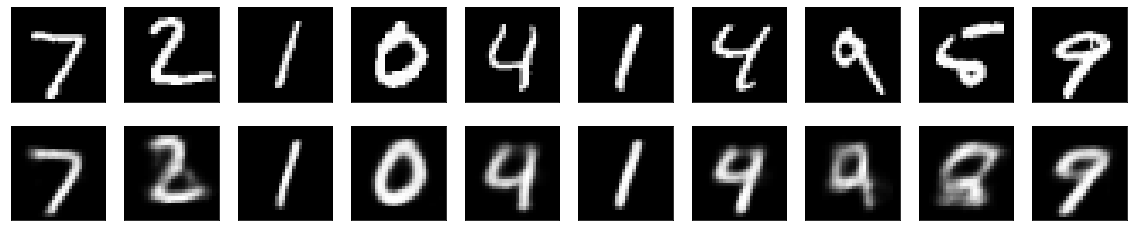

In [181]:
n = 10

imgs = x_test[:n]
encoded_imgs = encoder.predict(imgs, batch_size=n)
encoded_imgs = encoder.predict(imgs[:n],  batch_size=n)
decoded_imgs = decoder.predict(encoded_imgs, batch_size=n)

plot_digits(imgs,   decoded_imgs)

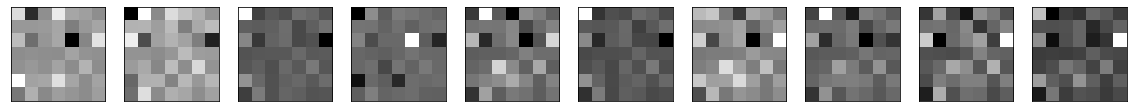

In [182]:
plot_digits(encoded_imgs.reshape(10,7,7,1))